# Regression with a feed forward neural network

Applied to predict temperature correlations at the atmosphere/ocean interface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from mlcdc import KerasFeeder

In [39]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

In [46]:
features = [
    #'atm_cnvprcp_ave', # no idea what this is
    #'atm_ast',
    #'atm_T',
    'atm_q2m',
    'atm_qrain',
    'atm_t2m',
    #'atm_totprcp_ave',
    'atm_tprcp',
    #'log10_atm_tprcp',
    #'atm_u_srf',
    #'atm_v_srf',
    'atm_speed_srf',
    'ocn_MEKE',
    #'ocn_MEKE_Kh', # probably need MEKE, if anything, not the diffusivity ...
    'ocn_MLD',
    #'ocn_MLD_MLE_filtered', # just use instantaneous, not time filtered version...
    #'ocn_ave_ssh', # use instantaneous version
    'ocn_sfc',
    'ocn_sst',
    #'ocn_u_srf',
    #'ocn_v_srf',
    'ocn_speed_srf',
    #'ocn_Temp',
]

In [47]:
for key in features:
    print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed


### Select correlation only at the surface

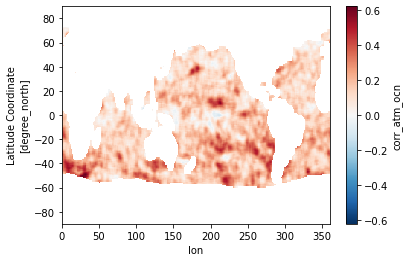

In [42]:
ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)
ds.corr_atm_ocn.plot()

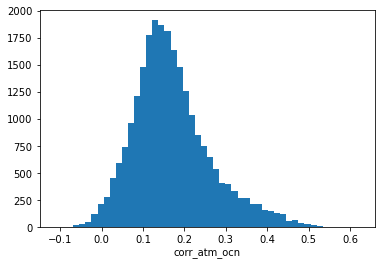

In [43]:
ds.corr_atm_ocn.plot.hist(bins=50);

In [44]:
df = ds[features].to_dataframe()

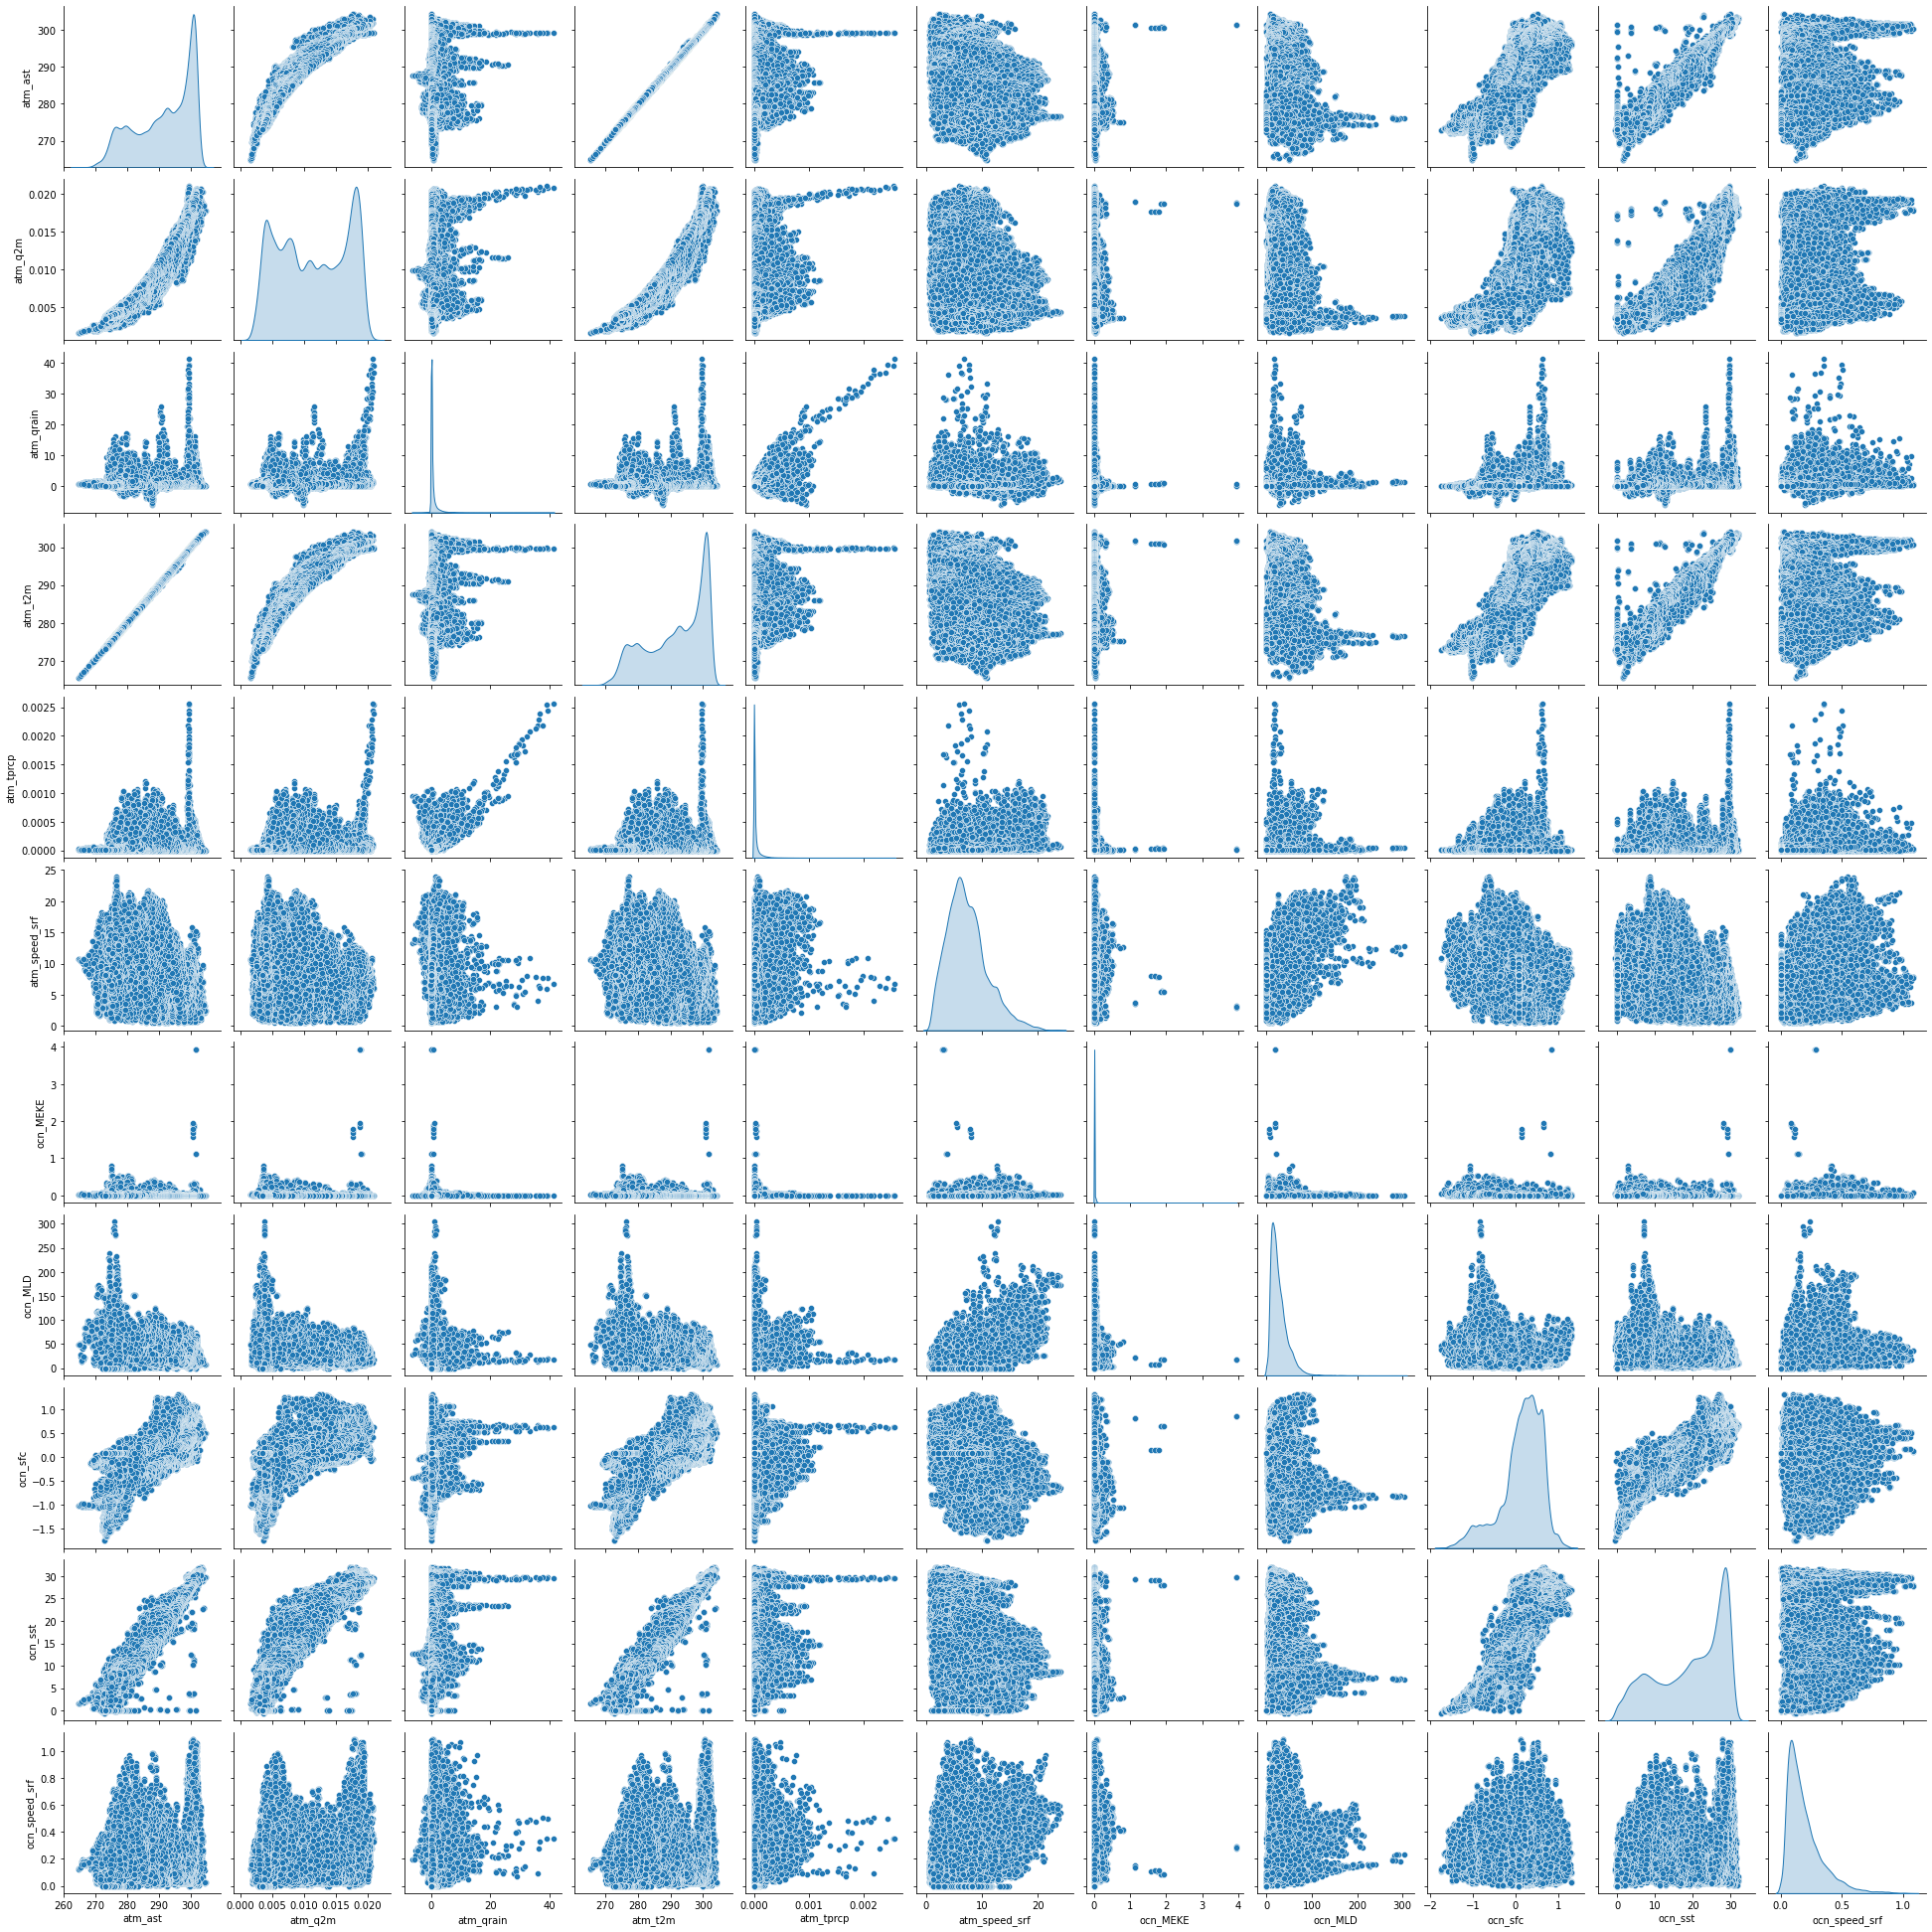

In [48]:
sns.pairplot(df, diag_kind='kde')

In [49]:
#features = ['atm_ast', 'atm_q2m', 'ocn_sst', 'ocn_sfc',
#            'atm_tprcp', 'ocn_MLD']

## Prepare the data

Using `KerasFeeder`

In [50]:
class SurfaceFeeder(KerasFeeder):
    @property
    def dim_order(self):
        return (self.sample_dim,)
    
    def get_mask(self, xds):
        mask = ~np.isnan(xds[self.label_name])
        mask = mask & xds[self.mask_name]
        return mask
    
    
    def stack_vertical(self, labels):
        return labels

In [51]:
kf = SurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [52]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf
        status = unset

    Labels:
        corr_atm_ocn
        status = unset

    Inputs:
        None
        status = unset

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True

In [53]:
kf(ds)

In [54]:
kf

KerasFeeder:

    Features:
        atm_q2m, atm_qrain, atm_t2m, atm_tprcp, atm_speed_srf, ocn_MEKE, ocn_MLD, ocn_sfc, ocn_sst, ocn_speed_srf
        status = set

    Labels:
        corr_atm_ocn
        status = set

    Inputs:
        [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_q2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_qrain')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_t2m')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_tprcp')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_speed_srf')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MEKE')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MLD')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sfc')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_sst')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_speed_s

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [153]:
def make_model(xkf, regularizer=keras.regularizers.L2, regularization=1e-6, ):
    merge = keras.layers.concatenate(xkf.inputs)
    
    hidden = keras.layers.Dense(
        units=16,
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(merge)
    
    hidden = keras.layers.Dense(
        units=32,
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(hidden)
    
    hidden = keras.layers.Dense(
        units=64,
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(hidden)
    
    hidden = keras.layers.Dense(
        units=64,
        activation='tanh',
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(hidden)
    
    hidden = keras.layers.Dense(
        units=64,
        activation='tanh',
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(hidden)
    
    hidden = keras.layers.Dense(
        units=64,
        activation='tanh',
        kernel_regularizer=regularizer(regularization),
        bias_regularizer=regularizer(regularization),
        #activity_regularizer=regularizer(regularization),
    )(hidden)
    
    #hidden = keras.layers.Dense(
    #    units=len(xkf.inputs),
    #    activation='swish',
    #    kernel_regularizer=regularizer(regularization),
    #    bias_regularizer=regularizer(regularization),
    #    #activity_regularizer=regularizer(regularization),
    #)(hidden)
    
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    # stick it together
    model = keras.Model(
        inputs=xkf.inputs,
        outputs=[output]
    )
    
    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=1e-4,
        ),
        loss=keras.losses.Huber(delta=1)
    )
    return model

In [192]:
model = make_model(kf,
                   regularizer=keras.regularizers.L2,
                   regularization=1e-7
                )

In [193]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atm_q2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_qrain (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 atm_t2m (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_tprcp (InputLayer)         [(None, 1)]          0           []                               
                                                                                           

In [195]:
%%time
history = model.fit(
    x=kf.x_training, 
    y=kf.labels['training'].values,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/200
496/496 [==============================] - 2s 2ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 2/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0025 - val_lo

496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 82/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 83/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 84/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 85/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 86/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 87/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 88/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 89/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 90/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 

Epoch 161/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 162/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 163/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 164/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 165/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 166/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 167/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 168/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 169/200
496/496 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 170/200
496/496 [==============================] - 1s 2ms/step - lo

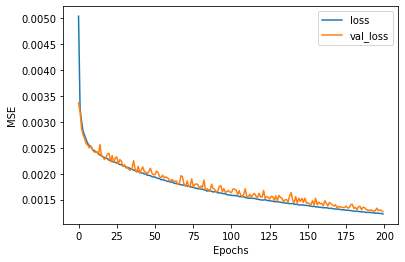

In [196]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

In [197]:
prediction = model.predict(kf.x_testing)
xpred = xr.DataArray(prediction.squeeze(),coords=kf.labels['testing'].coords, dims=kf.labels['testing'].dims)

619/619 [==============================] - 1s 994us/step


[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

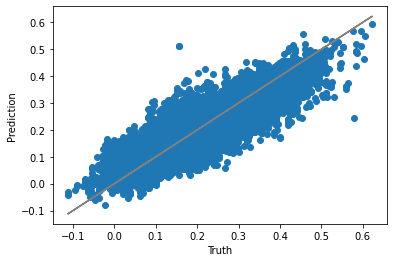

In [198]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'],
           xpred,
          )
ax.plot(kf.labels['testing'],
        kf.labels['testing'],
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

### Notes

- Setting regularization to ~$10^{-7} - 10^{-8}$ is what finally got the prediction to be at least span the 1:1 line 
- When regularization is too high, predictions well be a flat line (near zero)
- Low learning rate ~$10^{-4}$ seems to be good
- Huber loss was used here, but it's probably unnecessary

### Other things to try

- Other optimizers, e.g. with adaptive learning rate. See [this stackoverflow post](https://stackoverflow.com/questions/33919948/how-to-set-adaptive-learning-rate-for-gradientdescentoptimizer) and
[these experiments](https://github.com/vsmolyakov/experiments_with_python/blob/master/chp03/tensorflow_optimizers.ipynb)
- Potentially useful: http://uc-r.github.io/ann_regression
- How many layers is actually necessary? How wide is necessary? Activation functions?
- Residual Neural Network
- Can we add uncertainty?